# Pymeos and Pyspark Partitioning Demo

First we perform the corresponding imports for the libraries to use.

In [1]:
from pymeos import *

from pysparkmeos.UDT.MeosDatatype import TGeogPointInstUDT, TFloatInstUDT, STBoxUDT

from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType, TimestampType, DoubleType, FloatType
from pyspark.serializers import PickleSerializer
from pyspark.sql.functions import from_unixtime, col, udf, collect_list, count, monotonically_increasing_id, lit
from pysparkmeos.partitions.grid.grid_partitioner import GridPartition

from pysparkmeos.utils.udt_appender import udt_append
from pysparkmeos.UDF.udf import *
from pysparkmeos.partitions.mobilityrdd import MobilityRDD

from pyspark.sql.functions import max as psmax, min as psmin

import random, datetime

from datetime import timedelta
from functools import partial
from datetime import datetime, timezone
import contextily as cx
import distinctipy
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as shp
from pymeos.plotters import (
    TemporalPointSequenceSetPlotter,
    TemporalPointSequencePlotter,
)

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from shapely import wkb, box

## Initialize Pymeos and setup Pyspark

In [2]:
# Initialize PyMEOS
pymeos_initialize("UTC")

os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

#.config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("PySpark UDF Example with PyMEOS") \
    .master("local[*]") \
    .config("spark.default.parallelism", 12) \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# spark.sparkContext.setLogLevel("INFO")

# Append the UDT mapping to the PyMEOS classes
udt_append()

# Get the value of 'spark.default.parallelism'
default_parallelism = spark.sparkContext.getConf().get("spark.default.parallelism")
print(f"spark.default.parallelism: {default_parallelism}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/30 09:03:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


spark.default.parallelism: 12


## Read the DataFrame and create the columns of Pymeos data objects

In [3]:
# Read data from a CSV file
data_path = "../../small_states_2022-06-27-00.csv"  # Update this with your CSV file path
df = spark.read.csv(data_path, header=True, inferSchema=True).select("icao24", "time", "lat", "lon")

# Clean nans, if not Points can't be created
df = df.dropna(subset=["lat", "lon"])
    
# Convert the 'time' column to the correct format
df = df \
    .withColumn("time", from_unixtime(col("time"), "yyyy-MM-dd' 'HH:mm:ss")) \
    .withColumn("Point", create_point_udf("lat", "lon", "time")) \
    .withColumn("x", get_point_x("Point")) \
    .withColumn("y", get_point_y("Point")) \
    .withColumn("t", get_point_timestamp("Point"))
df = df.withColumn("PointStr", col("Point").cast("string")).withColumn("id", monotonically_increasing_id())

df.select("Point").write.mode("overwrite").csv("../../small_states_2022-06-27-00_only_points")

df.show(3, truncate=False)
    
boundaries = df.agg(
    psmax(col("x")).alias("max_x"),
    psmin(col("x")).alias("min_x"),
    psmax(col("y")).alias("max_y"),
    psmin(col("y")).alias("min_y"),
    psmax(col("t").cast("timestamp")).alias("max_t"),
    psmin(col("t").cast("timestamp")).alias("min_t"),
    psmax(col("lat")).alias("max_lat"),
    psmin(col("lat")).alias("min_lat")
)

# Get the bounding box of the data
bounds = boundaries.select(bounds_as_box("min_x", "max_x", "min_y", "max_y", "min_t", "max_t").alias("bounds"))
bounds.show(truncate=False)
boundstr = bounds.collect()[0]['bounds'].__str__()
bounds = STBox(boundstr, geodetic=True)
print(bounds.__str__(), type(bounds))
    
df.printSchema()

24/04/30 09:03:30 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/04/30 09:03:30 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------+-------------------+------------------+------------------+------------------------------------------------------------------+---------+--------+-------------------+------------------------------------------------------------------+---+
|icao24|time               |lat               |lon               |Point                                                             |x        |y       |t                  |PointStr                                                          |id |
+------+-------------------+------------------+------------------+------------------------------------------------------------------+---------+--------+-------------------+------------------------------------------------------------------+---+
|34718e|2022-06-27 00:00:00|40.87294006347656 |1.9229736328125   |POINT(1.9229736328125 40.87294006347656)@2022-06-27 00:00:00+00   |1.9229736|40.87294|2022-06-27 00:00:00|POINT(1.9229736328125 40.87294006347656)@2022-06-27 00:00:00+00   |0  |
|ac6364|2022-06-27 00:00

+-------------------------------------------------------------------------------------------------------------------------------------------+
|bounds                                                                                                                                     |
+-------------------------------------------------------------------------------------------------------------------------------------------+
|STBOX XT(((-177.02969360351562,-46.421356201171875),(177.816650390625,70.29727935791016)),[2022-06-27 00:00:00+00, 2022-06-27 00:15:00+00])|
+-------------------------------------------------------------------------------------------------------------------------------------------+



STBOX XT(((-177.02969360351562,-46.421356201171875),(177.816650390625,70.29727935791016)),[2022-06-27 00:00:00+00, 2022-06-27 00:15:00+00]) <class 'pymeos.boxes.stbox.STBox'>
root
 |-- icao24: string (nullable = true)
 |-- time: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- Point: pythonuserdefined (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)
 |-- t: timestamp (nullable = true)
 |-- PointStr: string (nullable = true)
 |-- id: long (nullable = false)



24/04/30 09:08:44 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/spark-f9e7c6e0-eedc-451e-a8d8-7d5aae2e5264/pyspark-08c8adc9-7e2c-4e6b-9de8-ab3637df503b. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/spark-f9e7c6e0-eedc-451e-a8d8-7d5aae2e5264/pyspark-08c8adc9-7e2c-4e6b-9de8-ab3637df503b
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:165)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:109)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:90)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1126)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun$new$4(ShutdownHookManager.scala:65)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun

## Generate the partitioning scheme and repartition data

In [4]:
# Now we calculate the grid and partition accordingly
gp = GridPartition(cells_per_side=3, bounds=bounds)
print(gp.num_partitions())
num_partitions = gp.num_partitions()
gridstr = gp.gridstr

# Register the udf
get_partition_key_udf = udf(gp.get_partition, IntegerType())


dfpoint = df.select("id", "Point", "PointStr").withColumn("partitionKey", get_partition_key_udf(col("Point"), lit(gridstr)))
dfpoint.show()

# dfpoint.select("_metadata").show(truncate=False)

# This operation can be costly, for testing do with few data points (<= 1000).
# dfpoint = dfpoint.coalesce(num_partitions, "partitionKey")
datardd = dfpoint.rdd.map(lambda x: (x['partitionKey'], x['Point'])).partitionBy(num_partitions)

27


+---+--------------------+--------------------+------------+
| id|               Point|            PointStr|partitionKey|
+---+--------------------+--------------------+------------+
|  0|POINT(1.922973632...|POINT(1.922973632...|          15|
|  1|POINT(-85.5262662...|POINT(-85.5262662...|           6|
|  2|POINT(1.838302612...|POINT(1.838302612...|          15|
|  3|POINT(-83.4583702...|POINT(-83.4583702...|           6|
|  4|POINT(-79.3079393...|POINT(-79.3079393...|           6|
|  5|POINT(8.005793644...|POINT(8.005793644...|          15|
|  6|POINT(8.388679504...|POINT(8.388679504...|          15|
|  7|POINT(-77.7057878...|POINT(-77.7057878...|           6|
|  8|POINT(52.04384408...|POINT(52.04384408...|          15|
|  9|POINT(-80.0497055...|POINT(-80.0497055...|           6|
| 10|POINT(134.1781997...|POINT(134.1781997...|          24|
| 11|POINT(-112.043282...|POINT(-112.043282...|           6|
| 12|POINT(-96.9305003...|POINT(-96.9305003...|           6|
| 13|POINT(153.0453608..

## Show the partition distribution

In [5]:
dfpoint.groupBy("partitionKey").count().show()

for idx, item in datardd.take(5):
    print(idx, item)

# datardd = dfpoint.rdd
# Function to count rows per partition
def count_in_partition(idx, iterator):
    cnt = 0
    for _ in iterator:
        cnt += 1
    return [(idx, cnt)]

# Using mapPartitionsWithIndex to count rows per partition
partition_counts = datardd.mapPartitionsWithIndex(count_in_partition).collect()
    
# Print the results
for partition_id, cnt in partition_counts:
    print(f"Partition {partition_id} has {cnt} rows")

+------------+-----+
|partitionKey|count|
+------------+-----+
|          15|  172|
|           6|  627|
|          24|   39|
|          18|   38|
|          21|   28|
|           3|   80|
|          12|   13|
|           9|    3|
+------------+-----+



3 POINT(-95.52649277907153 29.653518676757812)@2022-06-27 00:00:10+00
3 POINT(-81.2639842313879 29.27446785619703)@2022-06-27 00:00:10+00
3 POINT(-81.42393224379595 28.469253798662606)@2022-06-27 00:00:10+00
3 POINT(-98.94841918945309 30.053566108315678)@2022-06-27 00:00:10+00
3 POINT(-91.28577012282153 29.434616088867188)@2022-06-27 00:00:10+00


Partition 0 has 0 rows
Partition 1 has 0 rows
Partition 2 has 0 rows
Partition 3 has 80 rows
Partition 4 has 0 rows
Partition 5 has 0 rows
Partition 6 has 627 rows
Partition 7 has 0 rows
Partition 8 has 0 rows
Partition 9 has 3 rows
Partition 10 has 0 rows
Partition 11 has 0 rows
Partition 12 has 13 rows
Partition 13 has 0 rows
Partition 14 has 0 rows
Partition 15 has 172 rows
Partition 16 has 0 rows
Partition 17 has 0 rows
Partition 18 has 38 rows
Partition 19 has 0 rows
Partition 20 has 0 rows
Partition 21 has 28 rows
Partition 22 has 0 rows
Partition 23 has 0 rows
Partition 24 has 39 rows
Partition 25 has 0 rows
Partition 26 has 0 rows


## Plot the Projection of the grid and the distribution of data

root
 |-- id: long (nullable = false)
 |-- Point: pythonuserdefined (nullable = true)
 |-- PointStr: string (nullable = true)
 |-- partitionKey: integer (nullable = true)



/tmp/ipykernel_56971/699960129.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Text(143.09722222222223, 0.5, 'Lat')

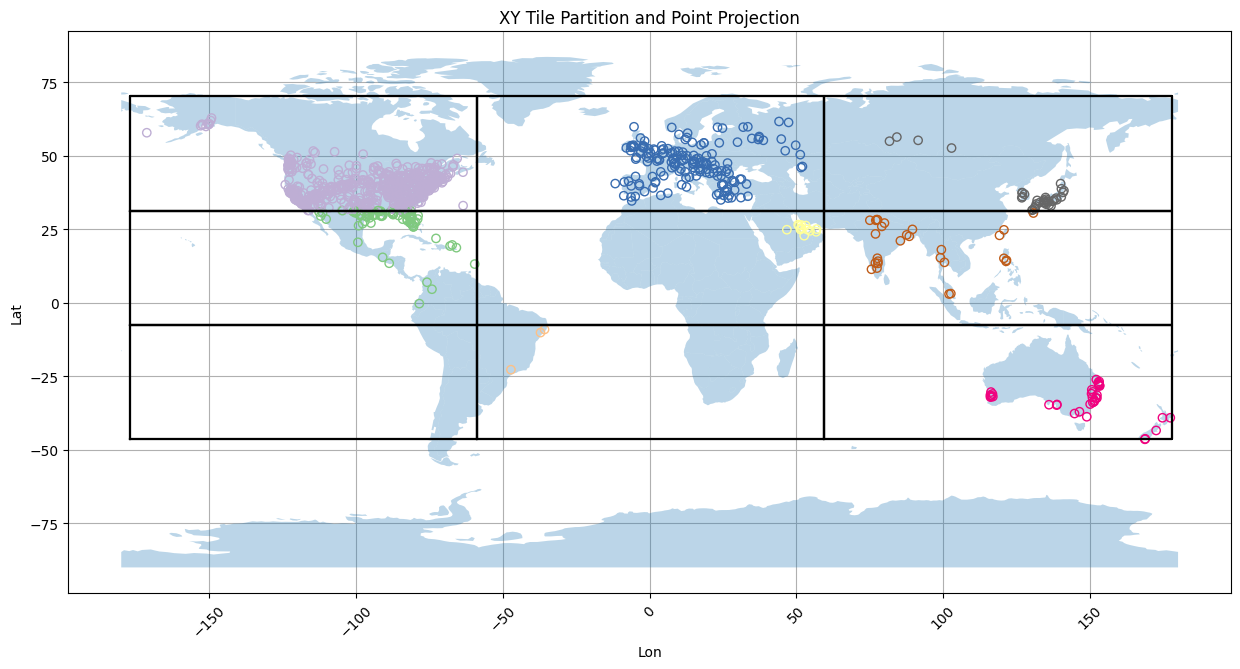

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# dfpoint = datardd.toDF(['partitionKey', 'Point'])
dfpoint.printSchema()

# Create a bounding box
# bounding_box = box(bounds.xmin(), bounds.ymin(), bounds.xmax(), bounds.ymax())

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, alpha=0.3)

colors = plt.cm.Accent(np.linspace(0, 1, len(gridstr)))
# Adding an alpha value when creating the color map
alpha_value = 1.0
color_map = {i: colors[i][:3].tolist() + [alpha_value] for i, tile in enumerate(gridstr)}
for i, tilestr in enumerate(gridstr):
    tile: STBox = STBox(tilestr).set_srid(0)
    tile.plot_xy(axes=ax, color="black", draw_filling=False)

for idx, row in enumerate(dfpoint.toLocalIterator()):
    if i == 1000:
        break
    point = row.Point
    if type(point)==str:
        point = TGeogPointInst(point)

    interp = point.interpolation()
    tpointseq = point.to_sequence(interp).plot(axes=ax,label="tpoint", color=color_map[row.partitionKey % gp.num_partitions()], facecolors='none')

plt.title("XY Tile Partition and Point Projection")
plt.xlabel("Lon")
plt.ylabel("Lat")

In [7]:
class TGeogPointInstWrap(TGeogPointInst):
    def __setstate__(self, state):
        print("Im being unpickled: ", state)
        self._inner = TGeogPointInst(state, srid=0)._inner

    def __getstate__(self):
        print("Im being pickled: ", self.__str__())
        return self.__str__()

pymeos_initialize()

tpoint = TGeogPointInstWrap("POINT(40.87294006347656 1.9229736328125)@2022-06-27 00:00:00+00",srid=0)

import pickle

pickled = pickle.dumps(tpoint)
unpickled = pickle.loads(pickled)
print(unpickled)

Im being pickled:  POINT(40.87294006347656 1.9229736328125)@2022-06-27 00:00:00+00
Im being unpickled:  POINT(40.87294006347656 1.9229736328125)@2022-06-27 00:00:00+00
POINT(40.87294006347656 1.9229736328125)@2022-06-27 00:00:00+00
